<table style="width: 100%; border-collapse: collapse;" border="0">
<tr>
<td><b>Created:</b> Tuesday 7 August 2018</td>
<td style="text-align: right;"><a href="https://github.com/douglask3/savanna_fire_feedback_test">github.com/douglask3/savanna_fire_feedback_test</td>
</tr>
</table>

<div>
<center>
<font face="Times">
<br>
<h1>Quantifying the uncertainity in climate potentials and mortality using Bayesian inference</h1>
<h2>Part 3: Posterior sampling</h2>
<br>
<br>
<sup>1,* </sup>Douglas Kelley, 
<sup>1 </sup>France Gerard, 
<sup>2 </sup>Rhys Whitley, 
<sup>3 </sup>Elmar Veenendaal
<br>
<br>
<br>
<sup>1 </sup>Centre for Ecology and Hydrology, Maclean Building, Crowmarsh Gifford, Wallingford, Oxfordshire, United Kingdom
<br>
<sup>2 </sup>Natural Perils Pricing, Commercial & Consumer Portfolio & Pricing, Suncorp Group, Sydney, Australia
<br>
<sup>3 </sup>Wageningen Univsersity, Wageningen UR
<br>
<br>
<h3>Summary</h3>
<hr>
<p> 
This notebook aims to quantify the model parameters of a global tree cover model model. Tree Cover is calculated as a product  precipitation, tempurature  and radiation controls describing large scale climate potetials, and mortality from fire, seasonal drought, tempuature and people, and exlusion from land use modulate tree cover. This limitation model for tree cover (LimTREE) is optimized using a Bayesian Inference framework, which provides a probability distribution for the models paramters, and allows us to describe the magnitude and relative impact of controls and varaibles in terms of probabilities. Here, we cover model description and optimization.
</p>
<br>
<br>
<br>
<i>Python code and calculations below</i>
<br>
</font>
</center>
<hr>
</div>

In [320]:
import sys
sys.path.append('../')

import warnings
warnings.filterwarnings('ignore')

import os
from   io     import StringIO
import numpy  as np
import pandas as pd
import csv

import iris
import matplotlib.pyplot as plt
import numpy.ma as ma
import cartopy.crs as ccrs
from   libs.plot_maps    import *
from scipy.stats import norm
from scipy.stats import skewnorm
from scipy.stats import lognorm
from pdb import set_trace as browser

def npLogit(x):
    return np.log(x/(1.0-x))

# We're using the row which has minimum sigma
def newCubes3D(variable, step, eg_cube_in, dimname = 'model_level_number', minV = -10, maxV = None):
    def newCube(i):
        coord = iris.coords.AuxCoord(i, dimname)
        eg_cube = eg_cube_in.copy()
        eg_cube.data[eg_cube.data > 0.0] = 0.0
        try:
            eg_cube.remove_coord(dimname)
        except:
            pass
        eg_cube.add_aux_coord(coord)
        return(eg_cube)
    
    if not hasattr(step, '__len__'):
        
        if minV is None: minV = np.round(npLogit(np.min(eg_cube_in.data[eg_cube_in.data>0.0]))) #* 2.0
        if maxV is None: maxV = -minV#np.round(npLogit(np.max(eg_cube_in.data[eg_cube_in.data<1.0])))
        
        minV = minV - 1
        step = np.arange(minV ,maxV, step)     
    
    eg_cubes = iris.cube.CubeList([newCube(i) for i in step])
    eg_cubes = eg_cubes.merge()[0]
    
    return(eg_cubes)


In [321]:
dir = "../data/driving_Data/TROPICS/"
pr_datasets   = ['GPCC', 'CRU']#, 'MSWEP', 'CMORPH']: 
drought_vars  = ['MADD', 'MADM']#, 'MConc', 'MDDM']:
fire_datasets = ['GFED_four_s', 'GFED_four']

files = {'map'           : 'MAP_'        ,
         'mat'           : 'MAT.nc'      ,
         'sw1'           : 'SW1.nc'      ,
         'sw2'           : 'SW2.nc'      ,
         'burnt_area'    : 'BurntArea_'  ,
         'drought'       : ''            ,
         'maxTemp'       : 'MTWM.nc'     ,
         'wind'          : 'MaxWind.nc'  ,
         'pop_density'   : 'PopDen.nc'   ,
         'pasture_area'  : 'pas.nc'      ,
         'urban_area'    : 'urban.nc'    ,
         'crop_area'     : 'crop.nc'     ,
         'Tree_cover'    : 'TreeCover.nc'}


In [322]:
param_file = '../outputs/params-paper1'
title_output = 'attempt3'

In [323]:
##open data
def loadInputsParams(pr_dataset, drought_var, fire_dataset):
    print(pr_dataset)
    print(drought_var)
    print(fire_dataset)
    
    input_data = {}
    for key, file in files.items():
        if key == "map": file = file + pr_dataset + '.nc'
        if key == "drought": file = drought_var + '_' + pr_dataset + '.nc'
        if key == "burnt_area": file = file + fire_dataset + '.nc'
        data = iris.load_cube(dir + '/' + file)
        if key == "map": data.data = np.log(data.data)
        if key == "mat" or key == "maxTemp": data.data = np.log(data.data + 273.15)
        input_data[key] = data
    
    params = pd.read_csv(param_file + '_' + pr_dataset + '_' + drought_var + '_' + fire_dataset +'.csv')
    return input_data, params
    
inputs = [[[loadInputsParams(pr, dr, fr) for pr in pr_datasets] for dr in drought_vars] for fr in fire_datasets]

GPCC
MADD
GFED_four_s
CRU
MADD
GFED_four_s
GPCC
MADM
GFED_four_s
CRU
MADM
GFED_four_s
GPCC
MADD
GFED_four
CRU
MADD
GFED_four
GPCC
MADM
GFED_four
CRU
MADM
GFED_four


In [324]:
inputs[0][0][0][0]

{'map': <iris 'Cube' of layer / (unknown) (latitude: 120; longitude: 720)>,
 'mat': <iris 'Cube' of layer / (unknown) (latitude: 120; longitude: 720)>,
 'sw1': <iris 'Cube' of layer / (unknown) (latitude: 120; longitude: 720)>,
 'sw2': <iris 'Cube' of layer / (unknown) (latitude: 120; longitude: 720)>,
 'burnt_area': <iris 'Cube' of layer / (unknown) (latitude: 120; longitude: 720)>,
 'drought': <iris 'Cube' of layer / (unknown) (latitude: 120; longitude: 720)>,
 'maxTemp': <iris 'Cube' of layer / (unknown) (latitude: 120; longitude: 720)>,
 'wind': <iris 'Cube' of layer / (unknown) (latitude: 120; longitude: 720)>,
 'pop_density': <iris 'Cube' of layer / (unknown) (latitude: 120; longitude: 720)>,
 'pasture_area': <iris 'Cube' of layer / (unknown) (latitude: 120; longitude: 720)>,
 'urban_area': <iris 'Cube' of layer / (unknown) (latitude: 120; longitude: 720)>,
 'crop_area': <iris 'Cube' of layer / (unknown) (latitude: 120; longitude: 720)>,
 'Tree_cover': <iris 'Cube' of layer / (un

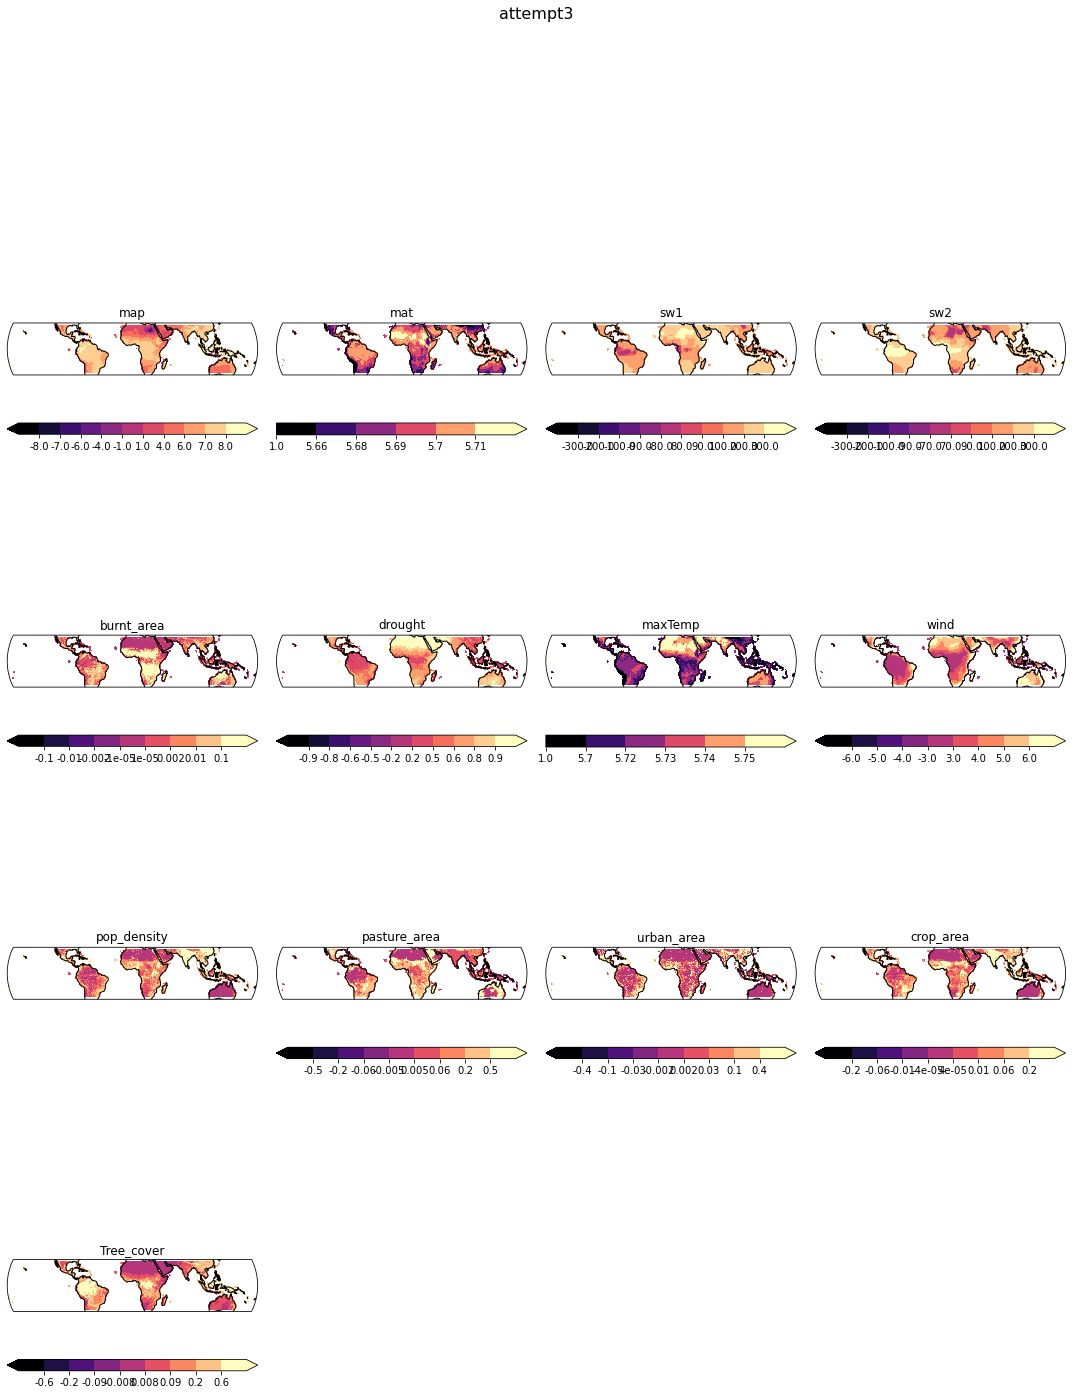

In [325]:
input_data = inputs[0][0][0][0]
nd = 0

plt.figure(figsize = (15, 20))

for key, dat in input_data.items():
    nd = nd + 1
    dat.long_name = key
    plot_lonely_cube(dat, 4, 4, nd, cmap = 'magma', levels = None)
    plt.suptitle(title_output, fontsize=16)
    plt.subplots_adjust(top=0.88)


In [326]:
class DeathCon(object):
    def __init__(self, data, params):
        """
        Initalise parameters and calculates the key variables needed to calculate burnt area.
        """
        self.params = params

        ## finds controls
        self.MAP = self.control_MAP(data['map'])
                                    
        self.MAT = self.control_MAT(data['mat'])
        
        self.SW = self.control_SW(data['sw1'], data['sw2'], self.params['trans_d'])       
        
                                    
        self.Mort = self.control_Mort(data['burnt_area'], data['drought'], data['maxTemp'], data['wind'], 
                                      data['pop_density'], 
                                      self.params['v_drought'], self.params['v_maxTemp'], self.params['v_wind'],
                                      self.params['v_popDen'], self.params['p_fire'],
                                      self.params['k_popden'], self.params['p_drought'])

        self.Exclude = self.control_Exclude(data['urban_area'], data['crop_area'], 
                                            data['pasture_area'],
                                            self.params['v_crop'], self.params['v_pas'])

        ## calculates limiting factor of each control.
        self.standard_MAP     = self.sigmoid(self.MAP,
                                             self.params['MAP_x0'], self.params['MAP_k'])  
        
        self.standard_MAT     = self.sigmoid(self.MAT,
                                            self.params['MAT_x0'], self.params['MAT_k']) 
        
        self.standard_SW      = self.sigmoid(self.SW,
                                            self.params['SW_x0'], self.params['SW_k']) 
        
        self.standard_Mort    = self.sigmoid(self.Mort,
                                            self.params['mort_x0'], -self.params['mort_k']) 
        
        self.standard_Exclude = self.sigmoid(self.Exclude,
                                            self.params['ex_x0'], -self.params['ex_k'])
                                                                           
        self.standard_Energy = self.standard_MAT * self.standard_SW
        self.error = self.params['sigma']
        ## burnt area us just limitation of each control muliplied together.
        self.Tree_cover_mode = self.standard_MAP * self.standard_MAT * self.standard_SW * \
            self.standard_Mort * self.standard_Exclude# * self.params['max_T']
        
        ## find the mean burnt area
        self.Tree_cover_calPDF(data)
        
        self.Tree_cover = self.Tree_cover_mean.copy() #* (1.0-self.p0)
        
        #browser()
        
        #self.standard_MAT    = self.standard_MAT / self.sigmoid(0.0, self.params['MAT_x0'],
        #                                         -self.params['MAT_k'])
        #self.standard_suppression = self.standard_suppression / self.sigmoid(0.0, self.params['suppression_x0'],
        #                                         -self.params['suppression_k'])

        self.potential_MAP = self.potential(self.standard_MAP, "potential_MAP")
        self.potential_MAT = self.potential(self.standard_MAT, "potential_MAT")
        self.potential_SW = self.potential(self.standard_SW, "potential_SW")
        self.potential_Mort = self.potential(self.standard_Mort, "potential_Mortality")
        self.potential_Exclude = self.potential(self.standard_Exclude, "potential_Exclude")
        self.potential_Energy = self.potential(self.standard_Mort, "potential_Energy")
        
        self.sensitivity_MAP = self.sensitivity(self.MAP, self.params['MAP_x0'], self.params['MAP_k'],
                                    self.standard_MAP, "sensitivity_MAP")

        self.sensitivity_MAT = self.sensitivity(self.MAT, self.params['MAT_x0'], -self.params['MAT_k'],
                                    self.standard_MAT, "sensitivity_MAT")

        self.sensitivity_SW = self.sensitivity(self.SW, self.params['SW_x0'], -self.params['SW_k'],
                                    self.standard_SW, "sensitivity_SW")

        self.sensitivity_Exclude = self.sensitivity(self.Exclude, self.params['ex_x0'], self.params['ex_k'],
                                    self.standard_Exclude, "sensitivity_Exclude")


        self.sensitivity_Mort = self.sensitivity(self.Mort, self.params['mort_x0'], -self.params['mort_k'] ,
                                    self.standard_Mort, "sensitivity_Mortality")

        

        self.sensitivity_Energy = self.sensitivity([self.MAT, self.SW], 
                                                   [self.params['MAT_x0'], self.params['SW_x0']],
                                                    [self.params['SW_k'], self.params['SW_k']],
                                                   self.standard_Energy, "sensitivity_Energy")
        ## if the inputs are iris cubes, we can add some useful metadata
        try:
            self.Tree_cover.long_name = "Tree_cover"
            self.Tree_cover_mode.long_name = "Tree_cover_mode"
            #self.burnt_area_median.long_name = "burnt_area_median"
            self.Tree_cover_mean.long_name = "Tree_cover_mean"

            self.MAP.long_name = "MAP"

            self.MAT.long_name = "MAT"
                                                                           
            self.SW.long_name = "SW"
            self.ignitions.units = 'Wm-2'

            self.Mort.long_name = "Mortality"
            self.Mort.units = '1'

            self.Exclude.long_name = "Exclude"
            self.Exclude.units = '1'

            self.standard_MAP.long_name = "standard_MAP"
            self.standard_MAT.long_name = "standard_MAT"
            self.standard_SW = "standard_SW"
            self.standard_Mort.long_name = "standard_Mortality"
            self.standard_Exclude.long_name = "standard_Exclude"

            self.standard_MAP.units     = '1'
            self.standard_MAT.units     = '1'
            self.standard_SW.units      = '1'
            self.standard_Mort.units    = '1'
            self.standard_Exclude.units = '1'
        except:
            pass        
    
      

    def control_MAP(self, map):
        """
        Definition to describe precip: while we are just returning input for now,
        we include climate potential functions for capability to be modified later.
        """
        return map


    def control_MAT(self, mat):#, min_mat, max_mat):
        """
        Definition to describe temp.
        """
        #mat = mat - min_mat
        #mat = mat / (max_mat - min_mat)
        #mat = tt.clip(mat, 0.0000001, 100000)
        #mat = tt.log(mat)
        return mat


    def control_SW(self, sw1, sw2, d):
        """
        Definition to describe short wave
        """
        return sw1 + d * sw2 /(1.0 + d)


    def control_Mort(self, fire, drought, maxTemp, wind, pop_density, v_drought, v_maxTemp, v_wind,
                     v_pop, p_fire, k_popden, p_drought):#, min_maxTemp, max_maxTemp, p_maxTemp):
        """
        Definition of mortality
        """
        #maxTemp = maxTemp - min_maxTemp
        #maxTemp = maxTemp / (max_maxTemp - min_maxTemp)
        #maxTemp = tt.clip(maxTemp, 0.0, 1.0)
        #maxTemp = maxTemp **(p_maxTemp)

        drought = drought ** (p_drought)
        pop_density.data = 1 - np.exp(pop_density.data * (-1.0/ k_popden))

        fire = fire**(p_fire)
        mort = fire  +  v_drought * drought  +  v_maxTemp * maxTemp  + v_wind * wind + v_pop * pop_density 

        return mort / (1.0 + v_drought + v_maxTemp + v_pop + v_wind)

    def control_Exclude(self, urban_area, crop_area, pasture_area, v_crop, v_pas):
        """
        Definition for the measure of fire supression
        """
        excl = urban_area  +  v_crop * crop_area + v_pas * pasture_area

        return excl / (1.0 + v_crop + v_pas)



    def sensitivity(self, x, x0, k, fi, long_name = None):
        
        if type(x) is list:
            gradients = [self.gradient(xi, x0i, ki) for xi, x0i, ki in zip(x, x0, k)]
            gradient = gradients[0]
            for g in gradients[1:]: gradient *= gradient
            
            gradient.data = gradient.data**len(gradients)            
        else:
            gradient = self.gradient(x, x0, k)
            
        if type(fi) is list:
            fis = fi.copy()
            fi = fis[0]
            for f in fis: fi *= f
                
            fi.data = fi.data**len(fis)
            
        sens = gradient * self.control_removal(fi)

        try: sens.units = '1'
        except: pass

        if long_name is not None:
            try: sens.long_name = long_name
            except: browser()
        return sens


    def control_removal(self, fi):
        return self.Tree_cover_mode/fi


    def potential(self, fi, long_name = None):
        out = fi.copy()
        out.data = self.Tree_cover_mode.data * ((1/out.data) - 1)

        try: out.units = '1'
        except: pass

        if long_name is not None:
            try: out.long_name = long_name
            except: pass
        return out


    def gradient(self, x, x0, k, dx = 0.0001):

        f1 = self.sigmoid(x + dx, x0, k)
        f2 = self.sigmoid(x - dx, x0, k)

        n1 = self.sigmoid(x0 + dx, x0, k)
        n2 = self.sigmoid(x0 - dx, x0, k)

        try:
            f1 = (f1 - f2)/(n1 - n2)
        except:
            f1.data = (f1.data - f2.data) / (n1.data - n2.data)

        return f1


    def sigmoid(self, x, x0,k):
        """
        Sigmoid function to describe limitation using tensor
        """
        try:
            out = x.copy()
            out.data = -k*(x.data - x0)
            out.data = 1.0/(1.0 + np.exp(out.data))
            x = out
        except:
            x = -k * (x - x0)
            x = 1.0/(1.0 + np.exp(x))
        return x
    
    def Tree_cover_calPDF(self, data):
        
        mask = np.logical_not(self.Tree_cover_mode.data.mask)
        self.Tree_cover_pdf = newCubes3D('Tree_cover', 0.5,
                                         data['Tree_cover'])
        
        self.Tree_cover_mean = self.Tree_cover_mode.copy()
        self.Tree_cover_mean.data[mask] = 0.0
        
        level_no = self.Tree_cover_pdf.coord('model_level_number').points
        
        dist = norm(npLogit(self.Tree_cover_mode.data[mask]), self.error)
        
        x = self.Tree_cover_pdf.coord('model_level_number').points
        for k in range(1, self.Tree_cover_pdf.shape[0]):       
            self.Tree_cover_pdf.data[k][mask] = dist.pdf(x[k])
            self.Tree_cover_mean.data[mask]  = self.Tree_cover_mean.data[mask] +  dist.pdf(x[k]) *(1/(1+np.exp(-x[k])))
                                     
        PDFtot = self.Tree_cover_pdf.collapsed(['model_level_number'], iris.analysis.SUM)
        
        self.Tree_cover_mean.data = self.Tree_cover_mean.data/ PDFtot.data
       
        
        

In [327]:
def bootSamples(x, samples, nsample = 2):
    def bootSample(x):
        #browser()or np.ma.is_masked(test)
        test = np.ma.sum(x)
        
        out = np.repeat(0, nsample)
        if test==0 : return out
        try:
            out = np.random.choice(samples, nsample, p =x/np.sum(x))
        except:
            out = np.repeat(0, nsample)
        return out
    x = np.apply_along_axis(bootSample, 0, x)
    return(x)



In [328]:
def runModelExperiment(input, paramLoc = None):
    
    input_data = input[0]
    params = input[1]
    #browser()
    if paramLoc is None: paramLoc = params["sigma"].idxmin()
    print("running")    
    
    model = DeathCon(input_data, params.loc[paramLoc])
    return model
    PDF = model.Tree_cover_pdf.data
    
    mask = PDF[0,:,:].mask == False
    TCs = model.Tree_cover_pdf.coord("model_level_number").points
    TCs = 1/(1+np.exp(-BAs))

    PDF = bootSamples(PDF[:,mask], TCs, 10)

    
    model_out.Tree_cover_pdf.data[:] = 0.0
    
    def posterize(i): return np.argmin(np.abs(i-TCs))
    vpost = np.vectorize(posterize)
    PDF_out = vpost(PDF_out)
    for PDF in PDF_out:
        for i in np.unique(PDF):
            test = PDF == i
            try:
                model_out.Tree_cover_pdf.data[i][mask] =+ test
            except:
                browser()
            
           
    return model_out
models = [[[runModelExperiment(input) for input in i] for i in j] for j in inputs]

running
running
running
running
running
running
running
running


### Tree Cover plot

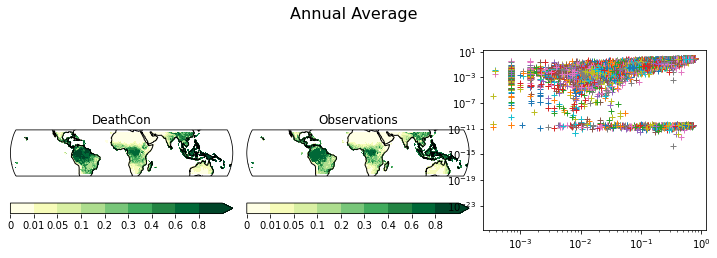

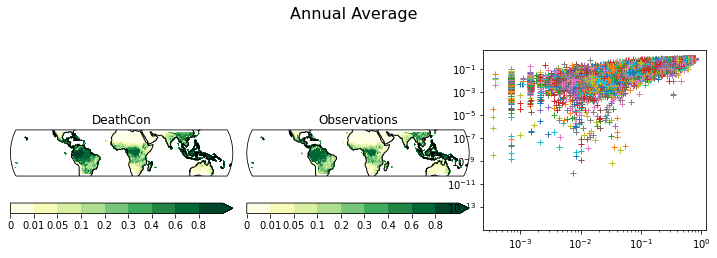

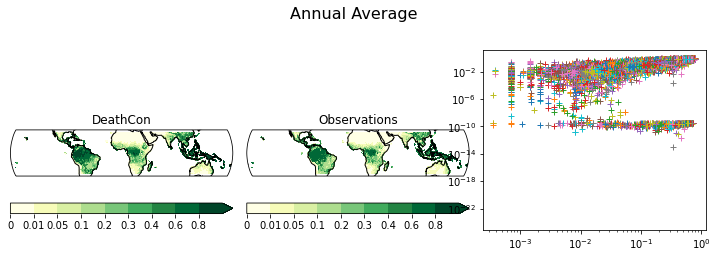

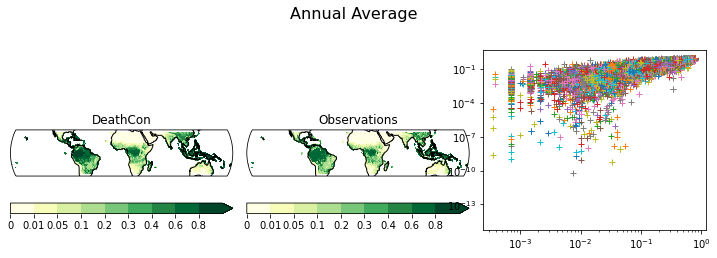

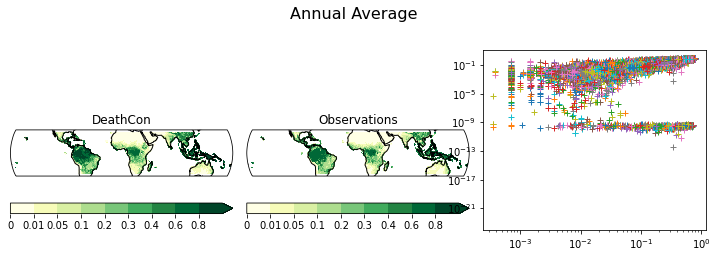

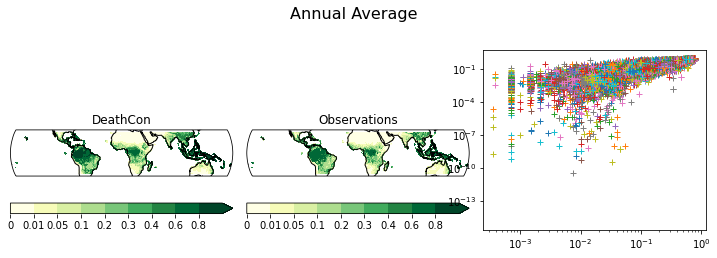

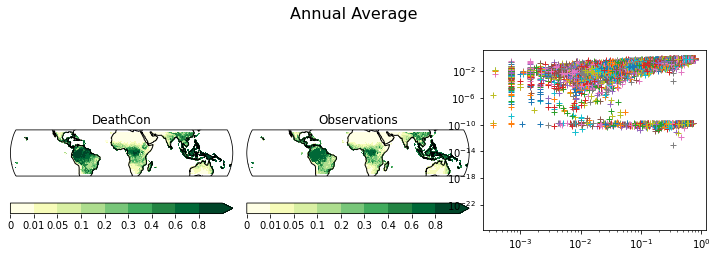

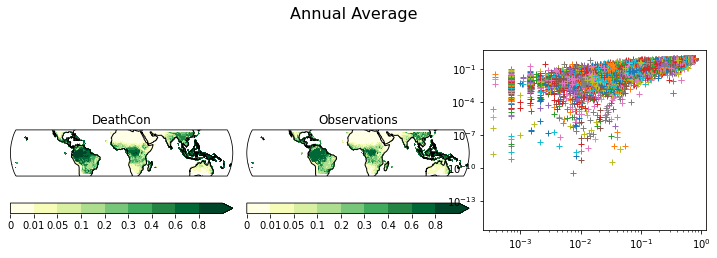

In [329]:
def plot_model_Tree_cover(model, level, addObs = False, 
                          figsize = (10, 6), Title = "Annual Average ", N = 2, M = 3, n = 0, 
                          addScatter = False, *args, **kw):
    if figsize is not None: plt.figure(figsize = figsize)
    
    sim = model.Tree_cover_mode    
    sim.long_name = "DeathCon"
    plot_lonely_cube(sim, N, M, n + 1, levels = level, cmap = "brewer_YlGn_09", *args, **kw)
    
    obs = inputs[0][0][0][0]["Tree_cover"]
    if addObs:
        obs.long_name = "Observations"
        plot_lonely_cube(obs, N, M, n + 2, levels = level, cmap = "brewer_YlGn_09", *args, **kw)
    
    if addScatter:
        plt.subplot(N, M, n + 3)
        plt.plot(obs.data, sim.data, '+')
        plt.gca().set_yscale('log')
        plt.gca().set_xscale('log')
    plt.subplots_adjust(top=0.88)
    plt.suptitle(Title, fontsize=16)
    plt.subplots_adjust(top=0.88)

            
clevels = [0, 0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.6, 0.8]


    
for model in models: 
    for mod in model: 
        for m in mod:
            plot_model_Tree_cover(m, clevels, extend = 'max', addObs = True, addScatter = True)
    
#plot_lonely_cube(model[0],[1], N, M, n + 1, levels = level, cmap = "brewer_YlOrRd_09", extend = 'max')

### Controls plot

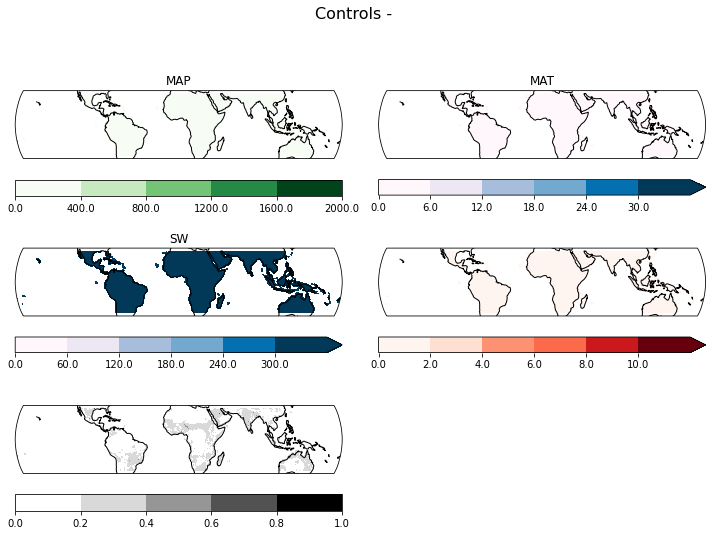

In [330]:
cmap_MAP = 'brewer_Greens_09'
cmap_Energy = 'brewer_PuBu_09'
cmap_Mortality = 'brewer_Reds_09'
cmap_Exclusion= 'brewer_Greys_09'

levels_frac = np.array([0,0.2, 0.4, 0.6,  0.8,  1.0])
#levels_frac = [0,0.45,  0.5, 0.55, 1.0]
#levels_ignitions = np.array([0, 100, 200,500, 1000, 2000, 5000])/5000.0
#levels_moisture = [0, 1, 1.1, 1.2, 1.3, 1.4, 1.5, 1.6]
    
def plotModComponet(comp, n, name = None, levels = None, scale = None, cmap = "brewer_YlOrRd_09",
                    N = 3, M = 2, *args, **kws):
    
    #comp = comp[mnths].collapsed('time', iris.analysis.MEAN)
    if name  is not None: comp.long_name = name
    plot_lonely_cube(comp, N, M, n, levels = levels, cmap = cmap, *args, **kws)


def plot_fire_month(model, Title = '',  **kw):    
    plt.figure(figsize = (10, 7.5))
    model = model
    plotModComponet(model.MAP, 1, cmap = cmap_MAP, levels = levels_frac*2000, **kw)
    plotModComponet(model.MAT, 2, cmap = cmap_Energy, levels = levels_frac*30, extend = 'max', **kw)
    plotModComponet(model.SW, 3, cmap = cmap_Energy, levels = levels_frac*300, extend = 'max', **kw)
    plotModComponet(model.Mort, 4, cmap = cmap_Mortality, levels = levels_frac*10, extend = 'max', **kw)
    plotModComponet(model.Exclude, 5, cmap = cmap_Exclusion, levels = levels_frac, **kw)
    plt.suptitle('Controls - ' + Title, fontsize=16)
    plt.subplots_adjust(top=0.88)
    
            
plot_fire_month(models[0][1][0])

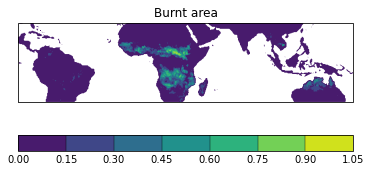

In [331]:
qplt.contourf(inputs[0][0][0][0]["burnt_area"])

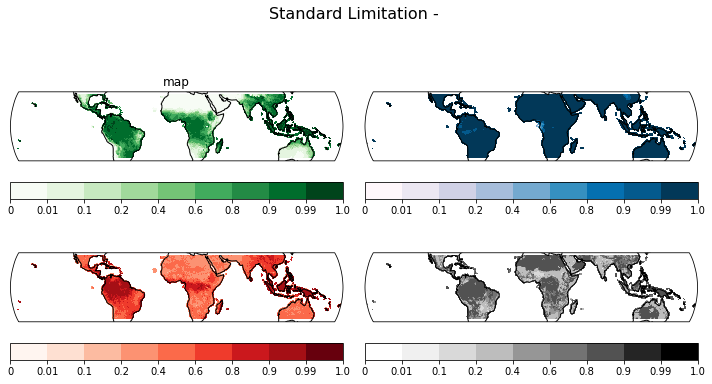

In [332]:
levels = [0, 0.01, 0.1, 0.2, 0.4, 0.6, 0.8, 0.9, 0.99, 1.0]
#levels = [0, 0.01, 0.02, 0.05, 0.1, 0.2,  0.5]
def plot_fire_month(model, **kw):
    
    plt.figure(figsize = (10, 7.5))
    plotModComponet(model.standard_MAP, 1, cmap = cmap_MAP, levels = levels, **kw)
    plotModComponet(model.standard_Energy, 2, cmap = cmap_Energy, levels = levels, **kw)
    plotModComponet(model.standard_Mort, 3, cmap = cmap_Mortality, levels = levels, **kw)
    plotModComponet(model.standard_Exclude, 4, cmap = cmap_Exclusion, levels = levels, **kw)
    plt.suptitle('Standard Limitation - ', fontsize=16)
    plt.subplots_adjust(top=0.88)
            
plot_fire_month(models[0][0][0])